## Finger Counting with Canny Edge Detection and Geometric Analysis

This project focuses on detecting the number of raised fingers in a hand image using a combination of edge detection and geometric analysis techniques.

---

**Date**: 3/07/25  
**Name**: Stefano  
**Surname**: Infusini  
**Student ID**: S5211120  

---

### Workflow

#### 1. Edge Detection and Processing

   - 1.1 **Edge Detection and Denoising**<br>
      Apply Gaussian filtering to reduce noise, followed by Canny edge detection to extract sharp hand contours.

   - 1.2 **Morphological Processing**<br>
      Use morphological operations (e.g., dilation, closing) to fill small gaps and smooth the edges of the hand.

   - 1.3 **Region Filling (Mask Creation)**<br> 
      Fill the interior of the smoothed contour to create a binary mask that clearly separates the hand from the background.

   - 1.4 **Contour Refinement**<br>
      Recalculate the edges on the binary mask to isolate a clean, continuous outer contour of the hand.

#### 2. Geometric Analysis

   - 2.1 **Convex Hull and Defect Detection**  
      Compute the convex hull to approximate the outer shape of the hand. Analyze convexity defects to identify valleys between fingers.

   - 2.2 **Geometric Filtering and Finger Counting**  
      Filter out invalid convexity defects based on angle and distance thresholds. Count the remaining valid defects, applying additional logic for special cases such as a closed fist or a single raised finger.

<br>
<br>

> **Note:**  
> While this project achieves good results on static hand images, its performance on real-time video input still leaves room for improvement. Achieving robust real-time accuracy would require more careful hyperparameter tuning and improved techniques for noise reduction and background suppression. These enhancements, however, fall outside the scope of this notebook, which is intended primarily to demonstrate the potential of edge detection when coupled with appropriate analysis.



### Various Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import skimage.color as color
import cv2
import pyautogui
from scipy import signal
from matplotlib import cm

plt.rcParams['figure.figsize'] = [10, 10]

### Functions

Utility functions used to carry on the project

In [7]:

def diffuse(edge_image, iterations=1):
    img = edge_image.copy()
    for _ in range(iterations):
        padded = np.pad(img, ((1,1),(1,1)), mode='constant')
        result = img.copy()
        for i in range(1, padded.shape[0] - 1):
            for j in range(1, padded.shape[1] - 1):
                if padded[i, j] > 0:
                    result[i-1:i+2, j-1:j+2] = 255  # set 3x3 neighborhood to white
        img = result
    return img


def contour(binary_img):
    height, width = binary_img.shape
    contour_points = []

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if binary_img[y, x] == 255:
                # Check 8-connected neighbors
                neighbors = binary_img[y-1:y+2, x-1:x+2]
                if np.any(neighbors == 0):  # If any neighbor is black
                    contour_points.append((x, y))
    return np.array(contour_points)

def add_border(image, color=(255, 255, 255), thickness=2):
    return cv2.copyMakeBorder(image, thickness, thickness, thickness, thickness,
                               cv2.BORDER_CONSTANT, value=color)

def put_centered_label(image, label, color=(255, 255, 255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8
    thickness = 1
    text_size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    text_x = (image.shape[1] - text_size[0]) // 2
    text_y = text_size[1] + 10
    cv2.putText(image, label, (text_x, text_y), font, font_scale, color, thickness)
    return image


def display_finger_detection_grid(results, expected_counts=None):
    """
    Displays a clean grid of finger detection results.

    Parameters:
    - results: List of tuples [(filename, detected_count, img_rgb), ...]
    - expected_counts: List of expected counts to display alongside detected counts (optional)
    """

    n_images = len(results)
    cols = 3
    rows = int(np.ceil(n_images / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten()

    for idx, (ax, (filename, detected_count, img_rgb)) in enumerate(zip(axes, results)):
        ax.imshow(img_rgb)
        expected = f"Expected: {expected_counts[idx]}" if expected_counts else ""
        ax.set_title(f"Detected: {detected_count} {expected}", fontsize=14)
        ax.axis('off')
        # Draw a white border for separation
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
            spine.set_linewidth(5)

    # Hide unused subplots
    for ax in axes[len(results):]:
        ax.axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.tight_layout()
    plt.show()

let's start by defining how the Canny Edge Detection works

### **1. Edge Detection & Processing**

reading the image

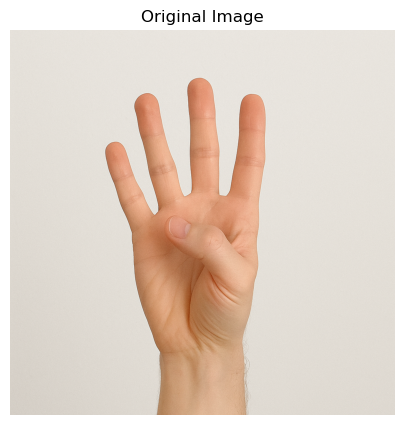

In [8]:
img = plt.imread('DATA/4.png')
if img.dtype != np.uint8:
    img = (img * 255).astype(np.uint8)
    
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

#### Canny Edge Detection

The Canny Edge Detection algorithm detects edges in an image through the following structured steps:

1. Smooth the image using a 2D Gaussian filter  
   This reduces noise in the image before performing edge detection.

2. Compute the image gradient using the Sobel operator  
   Calculate the gradients in the $x$ and $y$ directions to detect changes in intensity.

3. Calculate the gradient magnitude  
   At each pixel:
   $$
   G = \sqrt{G_x^2 + G_y^2}
   $$
   which indicates the edge strength at each location.

4. Calculate the gradient orientation  
   At each pixel:
   $$
   \theta = \arctan{\left(\frac{G_y}{G_x}\right)}
   $$
   which indicates the edge direction.

5. Apply non-maximum suppression (NMS)  
   Thin the edges by retaining pixels with the maximum gradient magnitude along the gradient direction while suppressing non-maximum pixels.

6. Perform double thresholding and edge tracking by hysteresis  
   - Apply high and low thresholds to distinguish strong edges from weak edges.
   - Use edge tracking to keep weak edges connected to strong edges while discarding isolated weak edges

In [9]:
def canny_edge_detection(image, low_threshold=0.1, high_threshold=0.3):
    return cv2.Canny(image, int(low_threshold * 255), int(high_threshold * 255))

##### 1.1 Edge Detection and Denoising

In [10]:
def to_grayscale(image):
    if len(image.shape) == 2:
        return image
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
def gaussian_smoothing(image, K_size=(0,0) ,sigma=1):
    return cv2.GaussianBlur(image, K_size, sigma)

In [11]:
img_gray = to_grayscale(img)
img_smoothed = gaussian_smoothing(img_gray, sigma=0.5)

Text(0.5, 1.0, 'Histogram of Smoothed Image')

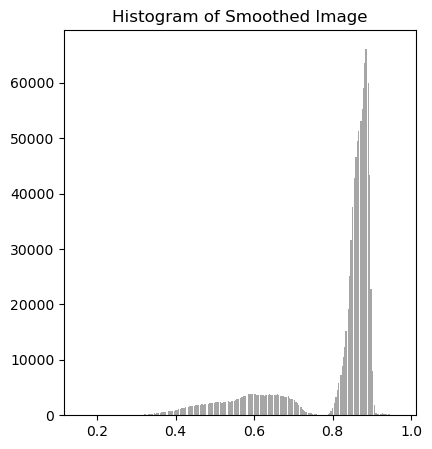

In [12]:
# plotting the histogram to find the best thresholds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist((img_smoothed/255).ravel(), bins=256, color='gray', alpha=0.7)
plt.title('Histogram of Smoothed Image') 

##### Noise vs Quality Threshold


Although the histogram suggests that a lower threshold around 0.6–0.7 and an upper threshold near 0.9 might be appropriate, in practice these values tend to miss parts of the hand’s contour. For robust finger detection, preserving the full outline of the hand is more important than eliminating all noise. Therefore, it’s better to use more conservative (i.e., lower) thresholds. This approach may admit a bit of extra noise, but it ensures that weaker edge segments—especially around the palm and wrist—are not lost. A complete and connected contour is crucial for later steps like convex hull analysis and finger separation.

For future, more general analysis, we plan to use even softer thresholds to improve robustness.

In [13]:
low_threshold = 0.2
high_threshold = 0.6
edges = canny_edge_detection(img_smoothed, low_threshold=low_threshold, high_threshold=high_threshold)

##### 1.2 Morphological Processing

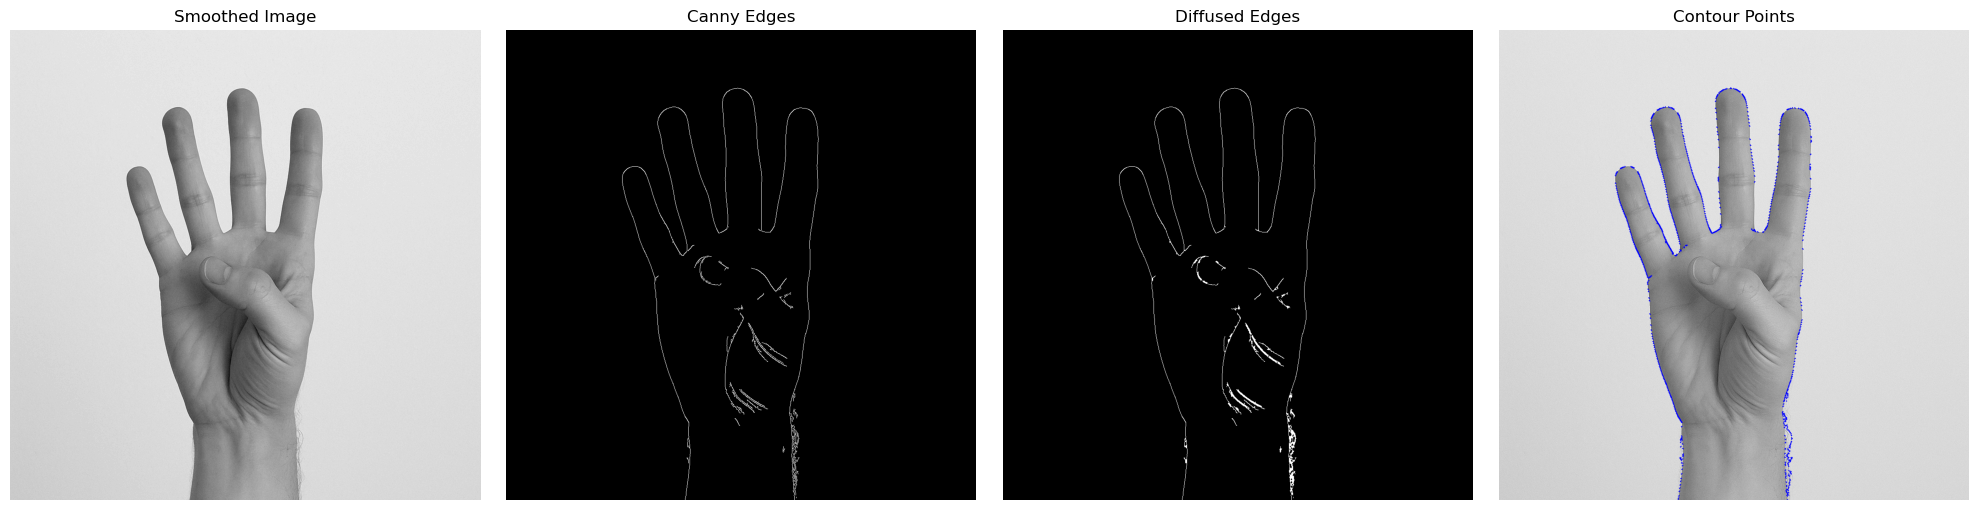

In [14]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))       # mainly used for morphological operations
edges_diffused = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)

contours, _ = cv2.findContours(edges_diffused, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_points = max(contours, key=cv2.contourArea)

# Visualize contour points on original image
contour_image = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
for point in contour_points:
    cv2.circle(contour_image, tuple(point[0]), 1, (0, 0, 255), -1)

# Plot all results in one figure
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(img_smoothed, cmap='gray'); axes[0].set_title('Smoothed Image'); axes[0].axis('off')
axes[1].imshow(edges, cmap='gray'); axes[1].set_title('Canny Edges'); axes[1].axis('off')
axes[2].imshow(edges_diffused, cmap='gray'); axes[2].set_title('Diffused Edges'); axes[2].axis('off')
axes[3].imshow(contour_image); axes[3].set_title('Contour Points'); axes[3].axis('off')
plt.tight_layout()
plt.show()

#### 1.3 Filling the region of the hand (mask creation)

In [15]:
def fill_edges(edges):
    h, w = edges.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    floodfilled = edges.copy()
    cv2.floodFill(floodfilled, mask, (0,0), 255)

    hand_filled = cv2.bitwise_not(floodfilled)   # Invert flood filled image to get the hand as white
    hand_filled_clean = cv2.bitwise_or(hand_filled, edges) # Combine filled hand with edges
    
    return hand_filled_clean # returns the filled shape of the hand

In [16]:
# redundant pass to refine the edges
#kernel = np.ones((5, 5), np.uint8)
#edges_binary_closed = cv2.dilate(edges_binary, kernel, iterations=2)
#edges = cv2.erode(edges_diffused, kernel, iterations=2)

hand_filled_clean = fill_edges(edges_diffused)

#### 1.4 Detecting the edges again for the filled hand

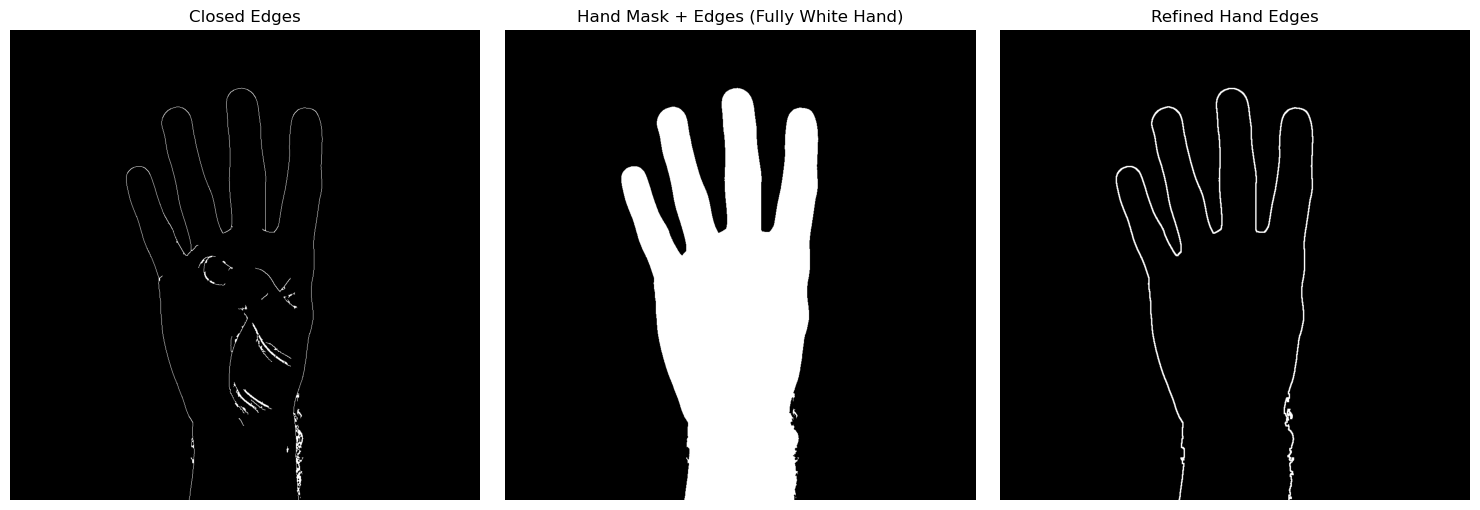

In [17]:
# find edges for the filled hand mask
hand_edges = canny_edge_detection(hand_filled_clean, low_threshold=0.1, high_threshold=0.3)

# calculating again the contour points for the hand edges
hand_edges_refined = diffuse(hand_edges, iterations=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(edges_diffused, cmap='gray'); axes[0].set_title('Closed Edges'); axes[0].axis('off')
axes[1].imshow(hand_filled_clean, cmap='gray'); axes[1].set_title('Hand Mask + Edges (Fully White Hand)'); axes[1].axis('off')
axes[2].imshow(hand_edges_refined, cmap='gray'); axes[2].set_title('Refined Hand Edges'); axes[2].axis('off')
plt.tight_layout()
plt.show()

Finally, we end up with the following edges

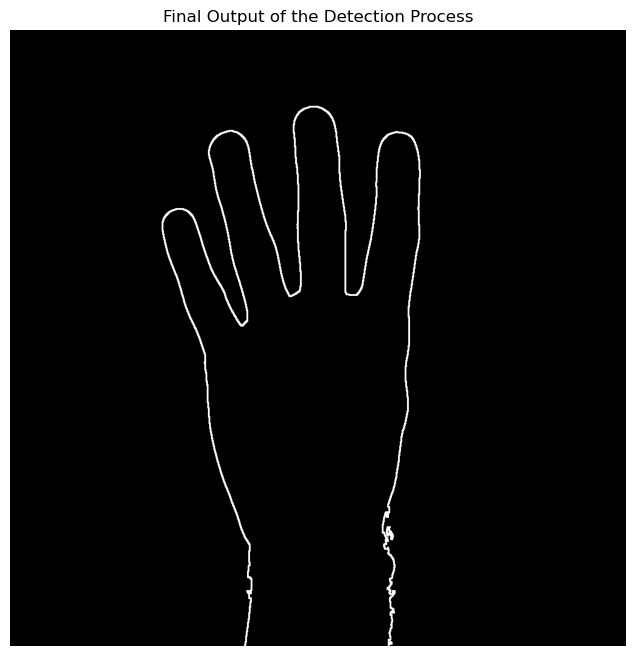

In [18]:
plt.figure(figsize=(8, 8))
plt.imshow(hand_edges_refined, cmap='gray')
plt.axis('off')
plt.title('Final Output of the Detection Process')
plt.show()

### **2. Geometric Analysis**

We now focus on how we can analyze the edges in order to count the number of fingers. 
It is immediate to understand that the quality of the detected edges plays a central role in obtaining a proper geometric analysis. 
That's why it is required for the 

#### 2.1 Convex Hull and Defect Detection  


To analyze the structure of the hand, we start by identifying its outer contour — the boundary that separates the hand from the background.

From this contour, we compute the convex hull, which is the smallest convex shape that completely encloses the hand. Geometrically, the convex hull smooths over the spaces between the fingers, resulting in a simplified, tight-fitting outline around the hand.

<img src="CH&D_explanation.png" alt="Convex Hull and Defects Illustration" width="400"/>

The core idea lies in comparing this idealized convex shape to the actual, more detailed hand contour. The differences between the two reveal meaningful features, such as the locations of valleys between fingers, which are essential for finger counting.

**Process:**

1. Find contour from refined edges  
2. Compute convex hull  
3. Find convexity defects  

In [19]:
contours, _ = cv2.findContours(hand_edges_refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

hand_contour_points = max(contours, key=cv2.contourArea)

hull = cv2.convexHull(hand_contour_points)  
hull_indices = cv2.convexHull(hand_contour_points, returnPoints=False)

test_img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
cv2.drawContours(test_img, [hand_contour_points], -1, (0, 255, 0), 2)

defects = cv2.convexityDefects(hand_contour_points, hull_indices)

#### 2.2 Finger Counting


The core of this section focuses on the analysis used to count the raised fingers. This is done by examining the convexity defects of the hand contour, which correspond to the inward valleys between fingers.

The key idea is that each raised finger typically creates a visible valley between itself and its neighboring fingers. By detecting and counting these pits, we can estimate how many fingers are extended. A filtering step is applied to remove shallow or irrelevant defects, ensuring that only meaningful finger gaps are considered.

Following the detailed procedure.

1. **Defect evaluation** 

   Each valley is checked for:
   - depth greater than a set threshold             
   - position lower than both start and end points  [ensuring we're detecting valleys with the fingertips as peaks]
   - sufficient distance from the bounding points   [valleys to close to the convex hull are suppressed]

   If all conditions are met, the defect is considered valid.

2. **Fallback logic**

   If no valid defects are found, the aspect ratio of the bounding box is used:  
   - a compact shape suggests a closed fist (0 fingers)  
   - a tall, narrow shape suggests a single raised finger

3. **Final count**

   The number of fingers is calculated as the number of valid defects plus one.

In [20]:
def count_fingers(hand_contour, defects, depth_threshold, min_distance_threshold):
    valid_defects = 0
    valid_defect_points = []
    debug_filtered_points = []

    for i in range(defects.shape[0]):
        s, e, f, d = defects[i][0]
        depth = d / 256.0

        start = tuple(hand_contour[s][0])
        end = tuple(hand_contour[e][0])
        far = tuple(hand_contour[f][0])

        dist_start_far = np.linalg.norm(np.array(start) - np.array(far))
        dist_end_far = np.linalg.norm(np.array(end) - np.array(far))

        if depth > depth_threshold:
            is_valley_down = far[1] > start[1] and far[1] > end[1]
            sufficient_distance = dist_start_far > min_distance_threshold and dist_end_far > min_distance_threshold

            if is_valley_down and sufficient_distance:
                valid_defects += 1
                valid_defect_points.append((int(far[0]), int(far[1])))
            else:
                debug_filtered_points.append((int(far[0]), int(far[1])))
        else:
            debug_filtered_points.append((int(far[0]), int(far[1])))

    # Check for closed wrist using aspect ratio
    if valid_defects == 0:
        x, y, w, h = cv2.boundingRect(hand_contour)
        aspect_ratio = h / w

        if aspect_ratio < 2:
            finger_count = 0  # closed wrist
        else:
            finger_count = 1  # flat hand without visible valleys
    else:
        finger_count = valid_defects + 1
    
    return finger_count, valid_defects, valid_defect_points, debug_filtered_points

In [21]:
finger_count, valid_defects, valid_defect_points, debug_filtered_points = \
    count_fingers(hand_contour_points, defects, depth_threshold=120, min_distance_threshold=50)

the following snippet extract further geometric properties for the sake of visualization

In [22]:
finger_count, valid_defects, valid_defect_points, debug_filtered_points = \
    count_fingers(hand_contour_points, defects, depth_threshold=120, min_distance_threshold=50)

valid_valley_info = []
for i in range(defects.shape[0]):
    s, e, f, d = defects[i,0]
    depth = d / 256.0

    start = tuple(hand_contour_points[s][0])
    end   = tuple(hand_contour_points[e][0])
    far   = tuple(hand_contour_points[f][0])

    dist_s_f = np.linalg.norm(np.array(start) - np.array(far))
    dist_e_f = np.linalg.norm(np.array(end)   - np.array(far))
    is_down  = (far[1] > start[1]) and (far[1] > end[1])

    if depth > 120 and dist_s_f > 50 and dist_e_f > 50 and is_down:
       # --- inside your valid_valley_info loop, instead of law‐of‐cosines: ---
        v1 = np.array(start, dtype=float) - np.array(far, dtype=float)
        v2 = np.array(end,   dtype=float) - np.array(far, dtype=float)
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        cos_theta = np.clip(cos_theta, -1.0, 1.0)               # avoid out‐of‐range
        angle = np.degrees(np.arccos(cos_theta))

        valid_valley_info.append((start, far, end, angle))

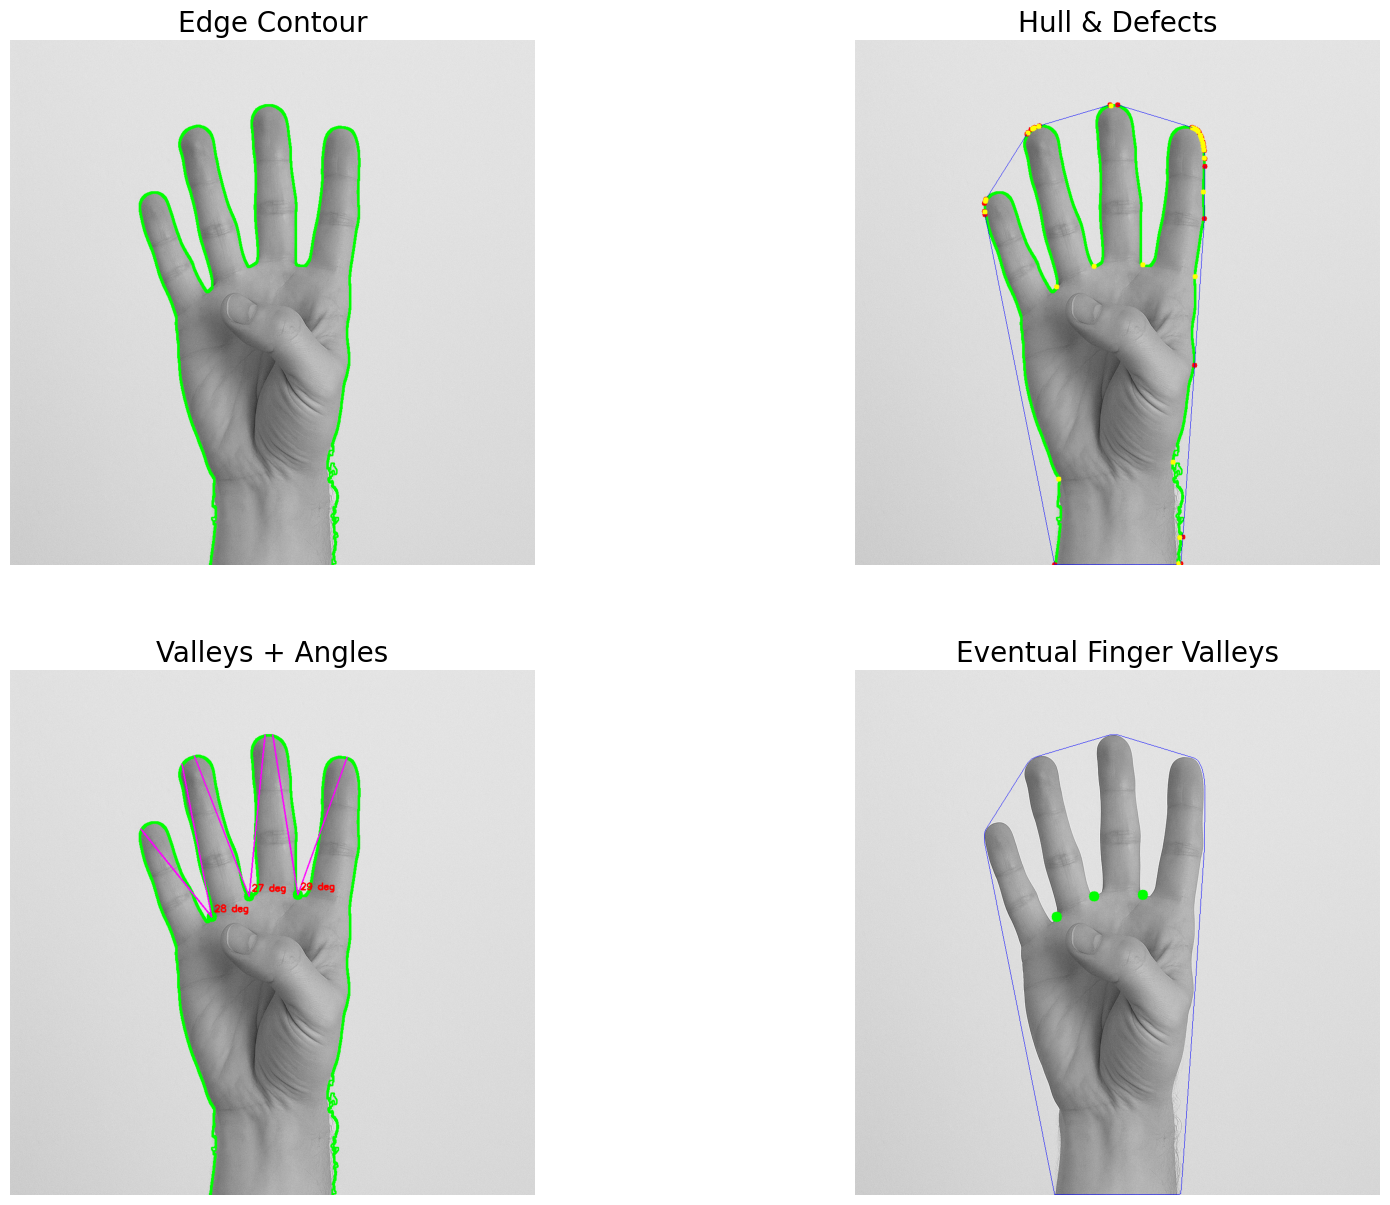

In [23]:
#-------------------------- Plotting --------------------------
# image A [contour only]
img_A = test_img.copy()

# image B [hull and defects]
img_B = test_img.copy()
for idx in hull_indices:
    cv2.circle(img_B, tuple(hand_contour_points[idx[0]][0]), 5, (0, 0, 255), -1)
for i in range(defects.shape[0]):
    s, e, f, _ = defects[i,0]
    cv2.line(img_B, tuple(hand_contour_points[s][0]), tuple(hand_contour_points[e][0]), (255, 0, 0), 1)
    cv2.circle(img_B, tuple(hand_contour_points[f][0]), 5, (0,255,255), -1)

# image C [valleys and angles]
img_C = test_img.copy()
for pt in valid_defect_points:
    cv2.circle(img_C, pt, 10, (0,255,0), -1)
for start, far, end, angle in valid_valley_info:
    cv2.line(img_C, far, start, (255,0,255), 2)
    cv2.line(img_C, far, end,   (255,0,255), 2)
    cv2.putText(img_C, f"{angle:.0f} deg", (far[0]+5, far[1]-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

# image D [final results]
img_D= cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
cv2.polylines(img_D, [hull], True, (255,0,0), 1)
for pt in valid_defect_points:
    cv2.circle(img_D, pt, 10, (0,255,0), -1)

fig, axes = plt.subplots(2, 2, figsize=(20,15))
titles = ['Edge Contour', 'Hull & Defects', 'Valleys + Angles', 'Eventual Finger Valleys']
imgs   = [img_A, img_B, img_C, img_D]
for ax, title, im in zip(axes.ravel(), titles, imgs):
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.set_title(title, fontsize=20)
    ax.axis('off')
plt.show()

Let's sum up a bit

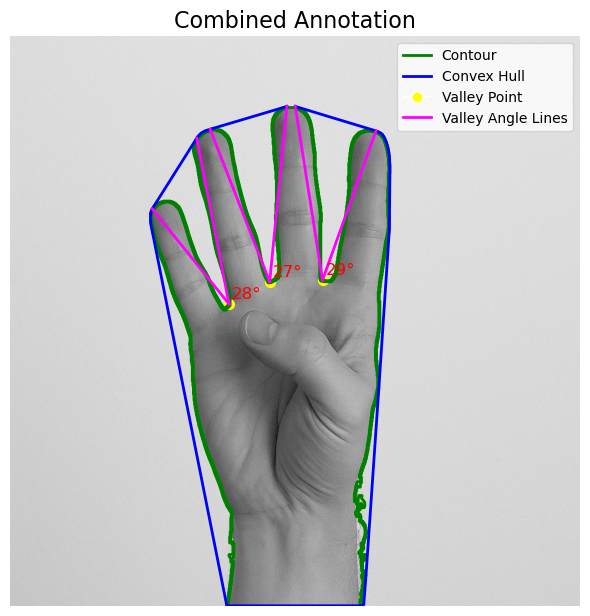

Total contour pts: 2704  |  Hull pts: 33
Contour shape: (2704, 1, 2)
Valid valley points & angles:
  1: (466, 441)   angle=27.0°
  2: (393, 481)   angle=27.9°
  3: (561, 438)   angle=28.6°
-> Total fingers counted = 4


In [24]:
# squeeze out singleton dims
contour = hand_contour_points.squeeze()   # → (N,2)
hull_pts = hull.squeeze()                # → (M,2)

fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(img_gray, cmap='gray')
ax.axis('off')
ax.set_title('Combined Annotation', fontsize=16)

# plot the hand contour (green)
ax.plot(contour[:, 0], contour[:, 1],
        color='green', linewidth=2)

# plot the convex hull (blue)
ax.plot(hull_pts[:, 0], hull_pts[:, 1],
        color='blue', linewidth=2)

# plot each valley point, its angle‐lines, and angle label
for start, far, end, angle in valid_valley_info:
    ax.scatter(far[0], far[1],
               color='yellow', s=50)   # valley point
    ax.plot([far[0], start[0]], [far[1], start[1]],
            color='magenta', linewidth=2)
    ax.plot([far[0], end[0]], [far[1], end[1]],
            color='magenta', linewidth=2)
    ax.text(far[0] + 5, far[1] - 10,
            f"{angle:.0f}°",
            color='red', fontsize=12)

# build and draw a proper Matplotlib legend
legend_elements = [
    Line2D([0], [0], color='green',  lw=2, label='Contour'),
    Line2D([0], [0], color='blue',   lw=2, label='Convex Hull'),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='yellow', markersize=8,
           label='Valley Point'),
    Line2D([0], [0], color='magenta', lw=2,
           label='Valley Angle Lines'),
]
ax.legend(handles=legend_elements,
          loc='upper right',
          framealpha=0.8)

plt.tight_layout()
plt.show()

print(f"Total contour pts: {len(hand_contour_points)}  |  Hull pts: {len(hull)}")
print(f"Contour shape: {hand_contour_points.shape}")
print("Valid valley points & angles:")
for i, (_, far, _, ang) in enumerate(valid_valley_info,1):
    print(f"  {i}: {far}   angle={ang:.1f}°")
    
print(f"\033[32m-> Total fingers counted = {finger_count}\033[0m")


#### **Let's now see the general case**

In [25]:
def process_and_count_fingers(
    img,
    to_grayscale,
    gaussian_smoothing,
    canny_edge_detection,
    fill_edges,
    diffuse,
    count_fingers,
    plot_debug=False
):

    img_gray = to_grayscale(img)
    img_smoothed = gaussian_smoothing(img_gray, sigma=0.5)
    edges = canny_edge_detection(img_smoothed, low_threshold=0.1, high_threshold=0.3)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    edges_diffused = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)

    # === Fill hand mask ===
    hand_filled_clean = fill_edges(edges_diffused)
    hand_edges = canny_edge_detection(hand_filled_clean, low_threshold=0.1, high_threshold=0.3)
    hand_edges_refined = diffuse(hand_edges, iterations=1)

    # === Find contours and convex hull ===
    contours, _ = cv2.findContours(hand_edges_refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours detected.")
        return img.copy(), 0

    hand_contour_points = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(hand_contour_points)
    hull_indices = cv2.convexHull(hand_contour_points, returnPoints=False)
    defects = cv2.convexityDefects(hand_contour_points, hull_indices)

    # === Count fingers ===
    finger_count, valid_defects, valid_defect_points, debug_filtered_points = count_fingers(
        hand_contour_points, defects,
        depth_threshold=120,
        min_distance_threshold=50
    )

    # === Prepare final annotated image ===
    original_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) if len(img.shape) == 2 or img.shape[2] == 1 else img.copy()
    cv2.polylines(original_img, [hull], isClosed=True, color=(255, 0, 0), thickness=2)
    for pt in valid_defect_points:
        cv2.circle(original_img, pt, 10, (0, 255, 0), -1)  # GREEN
    cv2.putText(original_img, f'{finger_count}', (30, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)

 
    return original_img, finger_count

# Collect results for batch plotting
results = []

for img_path in [
    "DATA/4.png", "DATA/7.png", "DATA/3.png",
    "DATA/2.png", "DATA/1.png", "DATA/5.png"
]:
    img = to_grayscale(cv2.imread(img_path))
    if img is None:
        print(f"[ERROR] Could not load {img_path}. Check path.")
        continue

    final_img, count = process_and_count_fingers(
        img,
        to_grayscale,
        gaussian_smoothing,
        canny_edge_detection,
        fill_edges,
        diffuse,
        count_fingers,
        plot_debug=False
    )

    final_img_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    results.append((img_path.split('/')[-1], count, final_img_rgb))

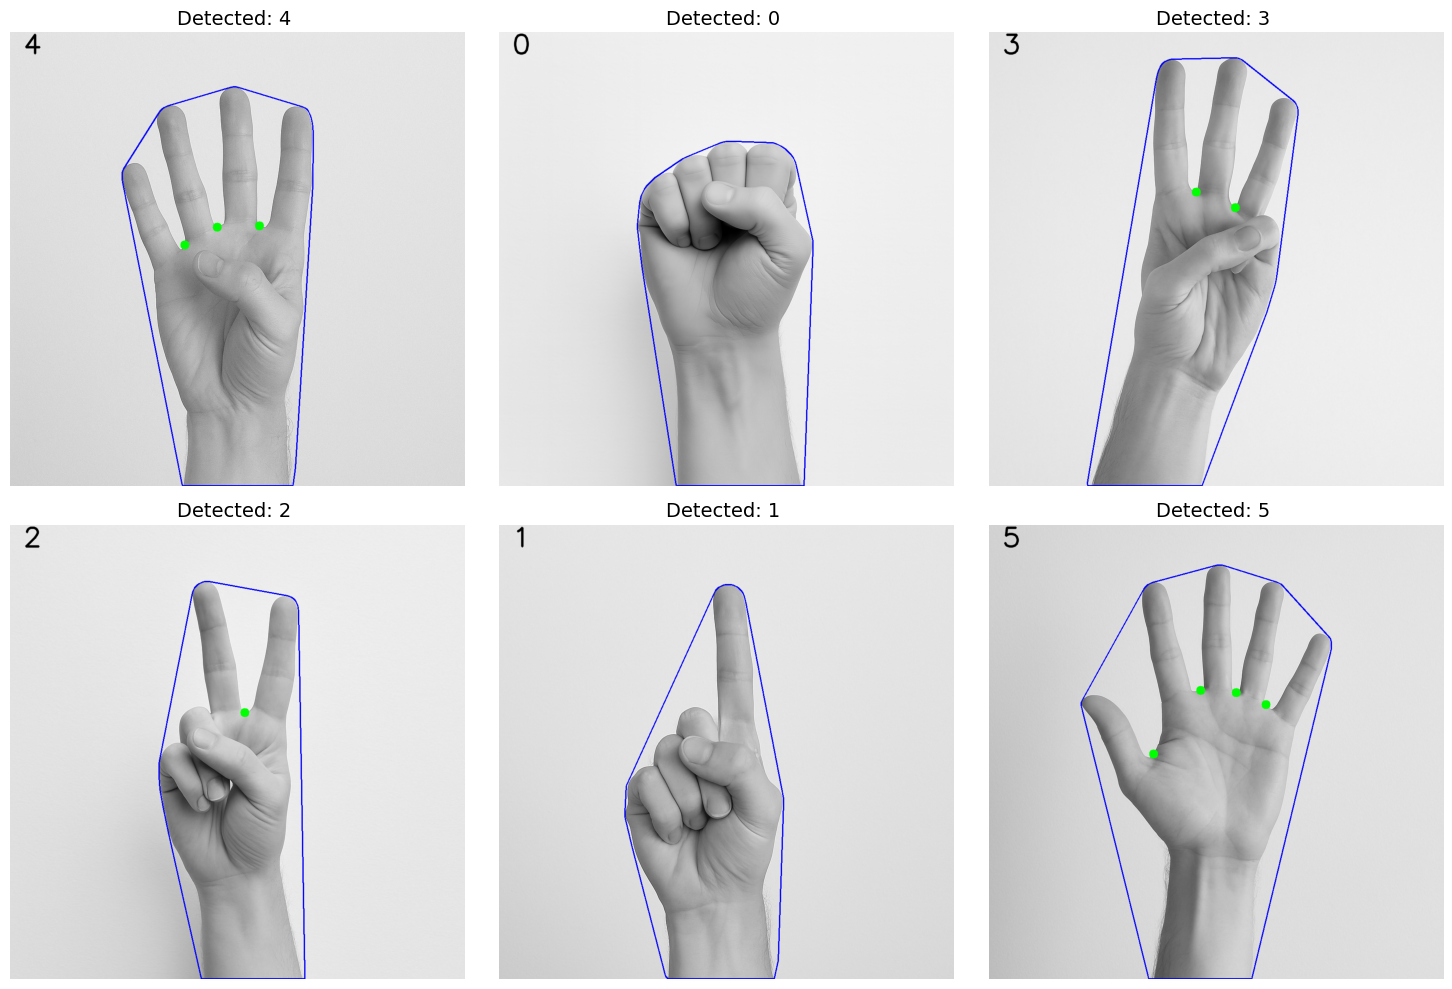

In [26]:
display_finger_detection_grid(results)

#### **Real-time test**

The following functions are used to implement a real-time finger counting system. In essence, they represent a reformulation of the previous concepts, with the main addition being background differentiation to isolate the hand from the scene.  
Detailed explanations are omitted, as they fall outside the scope of this notebook.


In [27]:
def count_fingers_from_contour(hand_contour,
                               drawing_img=None,
                               depth_threshold=80,
                               min_distance_threshold=50):
    """
    Counts the number of fingers raised from a single hand contour
    using convex hull and convexity defects analysis.
    
    Parameters:
        hand_contour: np.ndarray
            The contour points of the detected hand.
        drawing_img: np.ndarray or None
            Optional image to draw hull and defect points on for visualization.
        depth_threshold: float
            Minimum defect depth to consider a valid valley.
        min_distance_threshold: float
            Minimum distance between defect valley and hull points to avoid noise.
    
    Returns:
        finger_count: int
            The number of detected raised fingers.
    """
    # Compute convex hull and defects
    hull = cv2.convexHull(hand_contour, returnPoints=False)
    if hull is None or len(hull) < 3:
        return 0  # Not enough points for defect analysis

    defects = cv2.convexityDefects(hand_contour, hull)
    if defects is None:
        return 0

    valid_defects = 0

    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        depth = d / 256.0

        start = tuple(hand_contour[s][0])
        end = tuple(hand_contour[e][0])
        far = tuple(hand_contour[f][0])

        dist_start_far = np.linalg.norm(np.array(start) - np.array(far))
        dist_end_far = np.linalg.norm(np.array(end) - np.array(far))

        if depth > depth_threshold:
            is_valley_down = far[1] > start[1] and far[1] > end[1]
            sufficient_distance = dist_start_far > min_distance_threshold and dist_end_far > min_distance_threshold

            if is_valley_down and sufficient_distance:
                valid_defects += 1
                if drawing_img is not None:
                    cv2.circle(drawing_img, far, 8, (0, 255, 0), -1)  # Green for valid
            else:
                if drawing_img is not None:
                    cv2.circle(drawing_img, far, 8, (0, 0, 255), -1)  # Red for ignored
        else:
            if drawing_img is not None:
                cv2.circle(drawing_img, far, 8, (0, 0, 255), -1)  # Red for ignored

    # Check for closed wrist using aspect ratio
    if valid_defects == 0:
        x, y, w, h = cv2.boundingRect(hand_contour)
        aspect_ratio = h / w

        if aspect_ratio < 2:
            finger_count = 0  # closed wrist
        else:
            finger_count = 1  # flat hand without visible valleys
    else:
        finger_count = valid_defects + 1

    return finger_count

def run_finger_counter(
    sigma_gaussian=1,
    depth_threshold=80,
    min_distance_threshold=50,
    area_threshold=2000):
    """
    Launches an interactive webcam-based finger counting dashboard
    using background subtraction and Canny edge detection.

    Press:
        'b' -> Capture background for subtraction
        'q' -> Quit the interactive session

    Parameters:
    -----------
    sigma_gaussian : float
        Smoothing parameter for Gaussian blur.
    depth_threshold : float
        Minimum depth for convexity defects to consider as a finger valley.
    min_distance_threshold : float
        Minimum distance from defect valley to hull points to consider valid.
    area_threshold : float
        Minimum contour area to consider for hand detection.
    """

    cap = cv2.VideoCapture(0)
    background_blur = None

    cv2.namedWindow('Finger Counter Dashboard', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Finger Counter Dashboard', 1280, 720)

    print("[INFO] Press 'b' to capture background, 'q' to quit.")

    screen_width, screen_height = pyautogui.size()
    tile_width = screen_width // 2
    tile_height = screen_height // 2
    display_size = (tile_width, tile_height)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        frame_gray = to_grayscale(frame)
        frame_blur = gaussian_smoothing(frame_gray, sigma=sigma_gaussian)

        mask_display = np.zeros_like(frame_gray)
        edges_display = np.zeros_like(frame_gray)
        drawing_display = np.zeros_like(frame)
        finger_count = 0

        if background_blur is not None:
            diff = cv2.absdiff(background_blur, frame_blur)
            _, mask = cv2.threshold(diff, 35, 255, cv2.THRESH_BINARY)

            kernel = np.ones((5, 5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
            mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=1)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

            hand_only = cv2.bitwise_and(frame_blur, frame_blur, mask=mask)
            edges = canny_edge_detection(hand_only, low_threshold=0.1, high_threshold=0.3)

            contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            drawing = np.zeros_like(frame)

            if contours:
                max_contour = max(contours, key=cv2.contourArea)
                if cv2.contourArea(max_contour) > area_threshold:
                    cv2.drawContours(drawing, [max_contour], 0, (0, 255, 0), 2)
                    hull_points = cv2.convexHull(max_contour)
                    cv2.drawContours(drawing, [hull_points], 0, (255, 0, 0), 2)
                    finger_count = count_fingers_from_contour(
                        max_contour,
                        drawing_img=drawing,
                        depth_threshold=depth_threshold,
                        min_distance_threshold=min_distance_threshold
                    )

            mask_display = mask
            edges_display = edges
            drawing_display = drawing

        # Display overlay
        cv2.putText(frame, f'Fingers: {finger_count}', (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

        frame_disp = cv2.resize(frame, display_size)
        mask_disp = cv2.cvtColor(cv2.resize(mask_display, display_size), cv2.COLOR_GRAY2BGR)
        edges_disp = cv2.cvtColor(cv2.resize(edges_display, display_size), cv2.COLOR_GRAY2BGR)
        drawing_disp = cv2.resize(drawing_display, display_size)

        # Add borders
        frame_disp = add_border(frame_disp, color=(0, 255, 0))
        mask_disp = add_border(mask_disp, color=(255, 255, 255))
        edges_disp = add_border(edges_disp, color=(255, 255, 255))
        drawing_disp = add_border(drawing_disp, color=(255, 255, 255))

        # Add labels
        frame_disp = put_centered_label(frame_disp, "Original Feed")
        mask_disp = put_centered_label(mask_disp, "Background Mask")
        edges_disp = put_centered_label(edges_disp, "Canny Edges")
        drawing_disp = put_centered_label(drawing_disp, "Contours & Hull")

        # Stack dashboard
        top_row = np.hstack((frame_disp, mask_disp))
        bottom_row = np.hstack((edges_disp, drawing_disp))
        dashboard = np.vstack((top_row, bottom_row))

        cv2.imshow('Finger Counter Dashboard', dashboard)
        
        key = cv2.waitKey(1) & 0xFF

        if key == ord('b'):
            background_blur = frame_blur.copy()
            print("[INFO] Background captured for subtraction.")
        elif key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [28]:
'''run_finger_counter(
    sigma_gaussian=1,
    depth_threshold=80,
    min_distance_threshold=50,
    area_threshold=2000
)'''

'run_finger_counter(\n    sigma_gaussian=1,\n    depth_threshold=80,\n    min_distance_threshold=50,\n    area_threshold=2000\n)'

here we will show directly the results we obtain in a good setting

In [29]:
from IPython.display import Video
Video("demonstration.mp4", width=1280, height=720)

### **Conclusions**


This project was both engaging and insightful, particularly because edge detection provides a gateway to a wide range of visual analyses.
As stated in the introduction, the primary goal of this notebook was not to achieve high performance or perfect accuracy, but rather to explore the feasibility of using low-level features, such as edges, to extract meaningful, high-level information from images.

The results demonstrated that, under controlled conditions and with appropriate assumptions, the proposed method can yield promising outcomes. More importantly, it shows how structural features can be leveraged to interpret high-level semantic content, such as the number of raised fingers in an image.

This exploration serves as a proof of concept: it shows how relatively simple tools, when properly applied, can allow us to gather knowledge from data.

##### What Could Be Done Better

- Parameter tuning: Particularly for the real-time version, threshold values and filtering criteria could be further optimized to improve robustness.
- Finger-counting logic: Incorporating additional geometric cues such as the center of mass, finger width, or curvature could help handle more complex poses and noisy environments.
- Background robustness: A more adaptive background suppression strategy could allow the method to generalize better to real-world, cluttered scenes.
- A better generalisation capability: this project is likely overfitting the data used in this notebook.